<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/SecondStockEnivornment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Stock Trading Environment


  This second stock environment is based on Adam King's article as found here:[Create custom gym environments from scratch — A stock market example](https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e). Similar to the first stock trading environment based on Maxim Lapan's implementation as found in chapter eight of his book [Deep Reinforcement Learning Hands-On: Apply modern RL methods to practical problems of chatbots, robotics, discrete optimization, web automation, and more, 2nd Edition](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-optimization/dp/1838826998), the agent is trading in the environment of the [SPY ETF](https://www.etf.com/SPY?L=1) except in this trading environment the agent is taking continuous actions, rather than discrete actions and is tasked with managing a [trading account](https://www.investopedia.com/terms/t/tradingaccount.asp#:~:text=A%20trading%20account%20is%20an,margin%20requirements%20set%20by%20FINRA.).  



---


  In the first trading environment, the agent's reward is based on relative price movement, however in this trading environment the agent's reward is based on managing its trading account. As Adam King details the agent can take two actions: 1) either buying or selling the SPY ETF (none: eventhough this decision is discrete in nature, it is being modeled as a continous action by making values less than 1.0 as buy actions and values greater than 1.0 and less than 2.0 as sell actions);  and 2) by what percentage of the SPY ETF's shares to buy or sell, which ranges in the continous interval of [0-1] (i.e. 0% to 100%).











In [1]:
# ignore warning messages because they are annoying lol
import warnings
warnings.filterwarnings('ignore')

# Installing Necessary Package for Training the Trading Agent

To train the Trading Agent the package [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html) was used. As stated in the docs: 
> Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. It is the next major version of Stable Baselines. And steems from the paper [Stable-Baselines3: Reliable Reinforcement Learning Implementations](https://jmlr.org/papers/volume22/20-1364/20-1364.pdf)
The algorithms in this package will make it easier for the research community and industry to replicate, refine, and identify new ideas, and will create good baselines to build projects on top of. We expect these tools will be used as a base around which new ideas can be added, and as a tool for comparing a new approach against existing ones. We also hope that the simplicity of these tools will allow beginners to experiment with a more advanced toolset, without being buried in implementation details.

Because in this environment the Agent will be executing continous actions, two different RL algorithms were chosen. The first one was  Deep Deterministic Policy Gradient(DDPG) and the second one was Soft Actor Critic (SAC).  

---
### Deep Deterministic Policy Gradient(DDPG):

As stated by the authors of [CONTINUOUS CONTROL WITH DEEP REINFORCEMENT
LEARNING](https://arxiv.org/pdf/1509.02971.pdf):

> While DQN solves problems with high-dimensional observation spaces, it can only handle discrete and low-dimensional action spaces. Many tasks of interest, most notably physical control tasks, have continuous (real valued) and high dimensional action spaces. DQN cannot be straightforwardly applied to continuous domains since it relies on a finding the action that maximizes the
action-value function, which in the continuous valued case requires an iterative optimization process at every step. In this work we present a model-free, off-policy actor-critic algorithm using deep function approximators that can learn policies in high-dimensional, continuous action spaces. Here we combine the actor-critic approach with insights from the recent success of Deep Q Network [DQN](https://arxiv.org/pdf/1312.5602.pdf) 

**The key take aways from the algorithm are the following:** 

1.   Uses an actor-critic approach based on the [DPG algorithm](http://proceedings.mlr.press/v32/silver14.pdf) 
2.   A replay buffer is used to store transitions for sampling, since it is an off-policy algorithm
3.   A copy of the actor and critic networks, $Q_{\phi}(s,a|{\phi})$ and $µ_{\theta}(s|θ)$ respectively, are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks
4.   Batch normalization is used 
5.   An exploration policy is used by adding noise sampled from a noise process *N* to the actor policy  $µ_{\theta}(s_t)= µ(s_t |{\theta}, µ_t) + N$ 

*N* can be chosen to suit the environment, I used the Ornstein Uhlenbeck Noise as provided by Stable-Baselines

---
### Soft Actor Critic (SAC):

As stated by the authors of [Soft Actor-Critic:
Off-Policy Maximum Entropy Deep Reinforcement
Learning with a Stochastic Actor](https://arxiv.org/pdf/1801.01290.pdf):

> In this framework, the actor aims to maximize expected reward while also maximizing entropy. That is, to succeed at the task while acting
as randomly as possible.

**The key take aways from the algorithm are the following:** 

1.   Uses a maximum entropy objective rather than  the standard maximum
expected reward objective 
2.   Uses a soft policy iteration, which is a general algorithm for learning optimal maximum entropy policies that alternate between policy evaluation and policy improvement 
3.   SAC concurrently learns a policy  $\pi_{\theta}$ and two Q-functions  $Q_{\phi_1}$,  $Q_{\phi_2}$


In [3]:
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 30.1 MB/s 
     |████████████████████████████████| 1.5 MB 81.2 MB/s 
     |████████████████████████████████| 1.6 MB 57.9 MB/s 
     |████████████████████████████████| 1.1 MB 74.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=13a3a5f2c19ea89e35e274a6a8441d38a75ad95ef03632f0eef73fa324b605ad
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=f71e1016282d1c4b554fc5bb39458fa9b831c439c8ec6624fd1d6b814b9f818f
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c4

# Installing the Necessary Packages for Visualizing the Trading Agent's Envirnoment on Google Colab Notebooks

In [2]:
!pip install mpl_finance #used for plotting the candelstick graph
!pip install moviepy #
!pip install imageio_ffmpeg #
!pip install pyvirtualdisplay > /dev/null 2>&1 #used to create a display for vm
!apt-get install x11-utils > /dev/null 2>&1 #
!pip install pyglet==v1.3.2 > /dev/null 2>&1 #
!apt-get install -y xvfb python-opengl > /dev/null 2>&1 #

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 


In [5]:
import random
import json
import gym
from gym import spaces
from gym.utils import seeding
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import json
import datetime as dt
from stable_baselines3 import SAC, DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
import collections
import datetime
from mpl_finance import candlestick_ochl as candlestick
import math
import os
import moviepy.video.io.ImageSequenceClip
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

/usr/local/lib/python3.7/dist-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [ ]:
# Stock Environment Parameters
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_STEPS = 20000
TRADING_DAYS = 5
DEFAULT_COMMISSION_PERC = 0.01
INITIAL_ACCOUNT_BALANCE = 10000

# Visualization Parameters
style.use('dark_background')
VOLUME_CHART_HEIGHT = 0.20
UP_COLOR = '#27A59A'
DOWN_COLOR = '#EF534F'
UP_TEXT_COLOR = '#73D3CC'
DOWN_TEXT_COLOR = '#DC2C27'
LOOKBACK_WINDOW_SIZE = 10

# Video Parameters
image_folder='/content/frames/'
!mkdir '/content/frames'
fps=1
display = Display(visible=0, size=(1400, 900))
display.start()

 ## Creating visualization for Stock/ETF Environment
 As detalied by Adam King in his article titled
 [Rendering elegant stock trading agents using Matplotlib 
 and Gym](https://towardsdatascience.com/visualizing-stock-trading-agents-using-matplotlib-and-gym-584c992bc6d4)

In [ ]:
def date2num(date):
  converter = mdates.strpdate2num('%Y-%m-%d')
  return converter(date)

class StockTradingGraph:
  """A stock trading visualization using matplotlib made to render 
    OpenAI gym environments"""
  def __init__(self, df, title=None):
    self.df = df
    self.net_worths = np.zeros(len(df.date))
    # Create a figure on screen and set the title
    fig = plt.figure()
    fig.suptitle(title)
    # Create top subplot for net worth axis
    self.net_worth_ax = plt.subplot2grid((6, 1), (0, 0), rowspan=2,     
      colspan=1)
  
    # Create bottom subplot for shared price/volume axis
    self.price_ax = plt.subplot2grid((6, 1), (2, 0), rowspan=8, 
      colspan=1, sharex=self.net_worth_ax)
    # Create a new axis for volume which shares its x-axis with price
    self.volume_ax = self.price_ax.twinx()
    # Add padding to make graph easier to view
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.90, 
      top=0.90, wspace=0.2, hspace=0)
    
  
  def render(self, current_step, net_worth, trades, window_size=40):
    self.net_worths[current_step] = net_worth

    window_start = max(current_step - window_size, 0)
    step_range = range(window_start, current_step + 1)

    # Format dates as timestamps, necessary for candlestick graph
    dates = np.array([date2num(x) for x in self.df.date[step_range]])

    self._render_net_worth(current_step, net_worth, step_range, dates)
    self._render_price(current_step, net_worth, dates, step_range)
    self._render_volume(current_step, net_worth, dates, step_range)
    self._render_trades(current_step, trades, step_range)

    # Format the date ticks to be more easily read
    self.price_ax.set_xticklabels(self.df.date[step_range], rotation=45,
                                      horizontalalignment='right')

    # Hide duplicate net worth date labels
    plt.setp(self.net_worth_ax.get_xticklabels(), visible=False)
    plt.savefig(f'/content/frames/frame_{current_step}.png')

  
  def _render_net_worth(self, current_step, net_worth, step_range, dates):
    # Clear the frame rendered last step
    self.net_worth_ax.clear()

    # Plot net worths
    self.net_worth_ax.plot_date(dates, self.net_worths[step_range],
                                '-', label='Balance')

    # Show legend, which uses the label we defined for the plot above
    self.net_worth_ax.legend()
    legend = self.net_worth_ax.legend(loc=2, ncol=2, prop={'size': 8})
    legend.get_frame().set_alpha(0.4)

    last_date = date2num(self.df.date[current_step])
    last_net_worth = self.net_worths[current_step]

    # Annotate the current net worth on the net worth graph
    self.net_worth_ax.annotate('{0:.2f}'.format(net_worth), (last_date, last_net_worth),
                                   xytext=(last_date, last_net_worth),
                                   bbox=dict(boxstyle='round',
                                             fc='w', ec='k', lw=1),
                                   color="black",
                                   fontsize="small")

    # Add space above and below min/max net worth
    self.net_worth_ax.set_ylim(
            min(self.net_worths[np.nonzero(self.net_worths)]) / 1.25, max(self.net_worths) * 1.25)
    

  def _render_price(self, current_step, net_worth, dates, step_range):
        self.price_ax.clear()

        # Format data for OHCL candlestick graph
        candlesticks = zip(dates,
                           self.df.open[step_range], self._cur_close(step_range),
                           self._cur_high(step_range), self._cur_low(step_range))

        # Plot price using candlestick graph from mpl_finance
        candlestick(self.price_ax, candlesticks, width=1,
                    colorup=UP_COLOR, colordown=DOWN_COLOR)

        last_date = date2num(self.df.date[current_step])
        last_close = self._cur_close(current_step)
        last_high = self._cur_high(current_step)

        # Print the current price to the price axis
        self.price_ax.annotate('{0:.2f}'.format(last_close), (last_date, last_close),
                               xytext=(last_date, last_high),
                               bbox=dict(boxstyle='round',
                                         fc='w', ec='k', lw=1),
                               color="black",
                               fontsize="small")

        # Shift price axis up to give volume chart space
        ylim = self.price_ax.get_ylim()
        self.price_ax.set_ylim(ylim[0] - (ylim[1] - ylim[0])
                               * VOLUME_CHART_HEIGHT, ylim[1])
        
  def _render_volume(self, current_step, net_worth, dates, step_range):
        self.volume_ax.clear()

        volume = np.array(self.df.volume[step_range])

        pos = self.df.open[step_range] - \
            self._cur_close([step_range]) < 0
        neg = self.df.open[step_range] - \
            self._cur_close([step_range]) > 0

        # Color volume bars based on price direction on that date
        self.volume_ax.bar(dates[pos], volume[pos], color=UP_COLOR,
                           alpha=0.4, width=0.5, align='center')
        self.volume_ax.bar(dates[neg], volume[neg], color=DOWN_COLOR,
                           alpha=0.4, width=0.5, align='center')

        # Cap volume axis height below price chart and hide ticks
        self.volume_ax.set_ylim(0, max(volume) / VOLUME_CHART_HEIGHT)
        self.volume_ax.yaxis.set_ticks([])

  def _render_trades(self, current_step, trades, step_range):
        for trade in trades:
            if trade['step'] in step_range:
                date = date2num(self.df.date[trade['step']])
                high = self._cur_high(trade['step'])
                low = self._cur_low(trade['step'])

                if trade['type'] == 'buy':
                    high_low = low
                    color = UP_TEXT_COLOR
                else:
                    high_low = high
                    color = DOWN_TEXT_COLOR

                total = '{0:.2f}'.format(trade['total'])

                # Print the current price to the price axis
                self.price_ax.annotate(f'${total}', (date, high_low),
                                       xytext=(date, high_low),
                                       color=color,
                                       fontsize=8,
                                       arrowprops=(dict(color=color)))
                
  def _cur_close(self, offset):
      """
      Calculate real close price for the current bar
      """
      open = self.df.open[offset]
      rel_close = self.df.close[offset]
      return open * (1.0 + rel_close)

  def _cur_high(self, offset):
      """
      Calculate real close price for the current bar
      """
      open = self.df.open[offset]
      rel_high = self.df.high[offset]
      return open * (1.0 + rel_high)

  def _cur_low(self, offset):
      """
      Calculate real close price for the current bar
      """
      open = self.df.open[offset]
      rel_low = self.df.low[offset]
      return open * (1.0 + rel_low)

  def close(self):
    plt.close()
              
  

In [ ]:
# Stock/ETF Trading Enviornment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, random_ofs_on_reset=True, commission_prec=DEFAULT_COMMISSION_PERC):
        super(StockTradingEnv, self).__init__()

        self.data = data
        self.random_ofs_on_reset = random_ofs_on_reset
        self.bars_count = TRADING_DAYS
        self.commission_perc = commission_prec
        self.visualization = None 

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float32)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=self.shape)
        
        self.random_ofs_on_reset = random_ofs_on_reset
        self.seed()

    def reset(self):
      bars = self.bars_count
      if self.random_ofs_on_reset:
        offset = self.np_random.choice(self.data.high.shape[0]-bars*10)+bars
      else:
        offset = bars
      self._reset(offset)
      return self._next_observation()  

    @property
    def shape(self):
      return (4*self.bars_count+4, )

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        res = np.ndarray(shape=self.shape, dtype=np.float32)
        shift = 0
        for bar_idx in range(-self.bars_count+1, 1):
          res[shift] = self.data.high[self._offset + bar_idx]
          shift += 1
          res[shift] = self.data.low[self._offset + bar_idx]
          shift += 1
          res[shift] = self.data.close[self._offset + bar_idx]
          shift += 1
          res[shift] = self.data.volume[self._offset + bar_idx]
          shift += 1

        # Append additional data and scale each value to between 0-1
        res[shift] = self.balance / MAX_ACCOUNT_BALANCE
        shift += 1
        res[shift] = self.shares_held / MAX_NUM_SHARES
        shift += 1
        res[shift] = self.total_shares_sold / MAX_NUM_SHARES
        shift += 1
        res[shift] = self.total_shares_bought/MAX_NUM_SHARES
      
        return res

    def _take_action(self, action):

        reward = 0.0
        current_price = self._cur_close()
        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            total_possible = int(self.balance / current_price)
            total_possible = abs(total_possible)
            shares_bought = int(total_possible * amount)
            additional_cost = (shares_bought * current_price) + (shares_bought * current_price)*self.commission_perc

            # balance calculation 
            self.balance -= additional_cost
         

            self.shares_held += shares_bought
            self.total_shares_bought += shares_bought
            
            # visualization portion
            if shares_bought > 0:
              self.trades.append({'step': self._offset, 'shares': shares_bought, 
                                  'total': additional_cost, 'type': "buy"})

        elif action_type < 2:
            shares_sold = int(self.shares_held * amount)
            gain = (shares_sold * current_price) - (shares_sold * current_price)*self.commission_perc
            
            # balance calculation 
            self.balance += gain 
           

            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold

            # visualization portion
            if shares_sold > 0:
              self.trades.append({'step': self._offset, 'shares': shares_sold, 
                                  'total': gain, 'type': "sell"})
        
        self.net_worth = self.balance + self.shares_held * current_price
        reward += self.balance


        if self.net_worth > self.max_net_worth:
          self.max_net_worth = self.net_worth

        
        self._offset += 1

        return reward 

    def _cur_close(self):
      """
      Calculate real close price for the current bar
      """
      open = self.data.open[self._offset]
      rel_close = self.data.close[self._offset]
      return open * (1.0 + rel_close)

    def step(self, action):
        # Execute one time step within the environment
        reward = self._take_action(action)

        
        if self.balance <= 0 or self.net_worth >= MAX_ACCOUNT_BALANCE or self._offset >= self.data.close.shape[0]-1:
          done=True
        else:
          done=False


        obs = self._next_observation()

        return obs, reward, done, {}

    def _reset(self, offset):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.total_shares_bought = 0
        self._offset = offset
        self.trades = []


    def _render_to_file(self, filename='render.txt'):
      f = open(filename, 'a+')
      f.write(f"Step: {self._offset}\n")
      f.write(f"Balence: {self.balance}\n")
      f.write(f"Amount Held: {self.shares_held}\n") 
      f.write(f"Amount Sold: {self.total_shares_sold}\n)")
      f.write(f"Amount Bought: {self.total_shares_bought}\n")
      f.close()

    def render(self, mode='live', title="Agent's Trading Screen", **kwargs):
      # Render the environment to the screen
      if mode == 'file':
        self._render_to_file(kwargs.get('filename', 'render.txt'))
      elif mode == 'live':
        if self.visualization == None:
          self.visualization = StockTradingGraph(self.data, title)
        
        self.visualization.render(self._offset, self.net_worth,
                                    self.trades, window_size=LOOKBACK_WINDOW_SIZE)


    def seed(self, seed=None):
      self.np_random, seed1 = seeding.np_random(seed)
      seed2 = seeding.hash_seed(seed1+1) % 2**33
      return [seed1, seed2]


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/StockMarketData/archive/Data/ETFs/spy.us.txt')
df = df.sort_values('Date')
data=df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# year data of year-month-day form
dt = data['Date'].array
# calculating relative prices 
rh = (data['High'].values-data['Open'].values)/data['Open'].values
rl = (data['Low'].values-data['Open'].values)/data['Open'].values
rc = (data['Close'].values-data['Open'].values)/data['Open'].values
o = data['Open'].values
# volumne data
vol = data['Volume'].values

Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume'])
data=Data(date=dt,high=rh, low=rl, close=rc, open=o, volume=vol)

In [ ]:
# The algorithms require a vectorized environment to run
env = StockTradingEnv(data)
model = PPO("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=MAX_STEPS)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44.3     |
|    ep_rew_mean     | 7.99e+04 |
| time/              |          |
|    fps             | 678      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 46.1         |
|    ep_rew_mean          | 8.85e+04     |
| time/                   |              |
|    fps                  | 494          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0042863684 |
|    clip_fraction        | 0.00693      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -1.55e-06    |
|    learning_r

[MoviePy] >>>> Building video agent_trading.mp4
[MoviePy] Writing video agent_trading.mp4


 99%|█████████▉| 100/101 [00:00<00:00, 157.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: agent_trading.mp4 



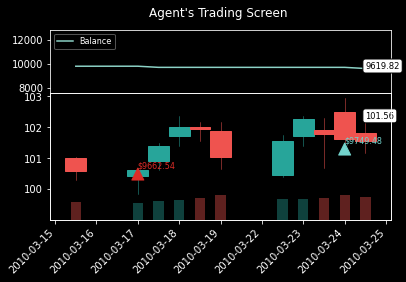

In [ ]:
obs = env.reset()
# 100 trading days
for i in range(100):
  action, _states = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  env.render()
  # if done:
  #   break

# taken from https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('agent_trading.mp4')

In [ ]:
# taken from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT

def show_video():
  mp4list = glob.glob('agent_trading.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
show_video()

In [ ]:
!rm -r frames/